Initial imports

In [1]:
pip install torchmetrics #google colab runtimes don't have torchmetrics installed

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
from torchmetrics.classification import MulticlassAccuracy, F1Score, Precision, Recall
import torch.nn as nn
from torch.nn import functional as F
import torchaudio
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
Xr_train = torch.load("/content/drive/MyDrive/ravdess/Xr_train.pt")
Xr_test = torch.load("/content/drive/MyDrive/ravdess/Xr_test.pt")
Xr_val = torch.load("/content/drive/MyDrive/ravdess/Xr_val.pt")

y_train = torch.load("/content/drive/MyDrive/ravdess/y_train.pt")
y_test = torch.load("/content/drive/MyDrive/ravdess/y_test.pt")
y_val = torch.load("/content/drive/MyDrive/ravdess/y_val.pt")

In [5]:
Xc_train = torch.load("/content/drive/MyDrive/ravdess/Xc_train.pt")
Xc_val = torch.load("/content/drive/MyDrive/ravdess/Xc_val.pt")

yc_train = torch.load("/content/drive/MyDrive/ravdess/yc_train.pt")
yc_val = torch.load("/content/drive/MyDrive/ravdess/yc_val.pt")

In [6]:
Xc_train.shape

torch.Size([6540, 182, 440])

In [7]:
# hyperparameters
token_size = 440
n_embd = 32
n_head = 1
n_layer = 1
dropout = 0.1
# ------------

# def get_batch(split):
#   X = X_train if split == 'train' else X_val
#   Y = y_train if split == 'train' else y_val

#   ix = torch.randint(len(X), (batch_size,))
#   x = torch.stack([X[i] for i in ix])
#   y = torch.cat([Y[i] for i in ix])
#   x, y = x.to(device), y.to(device)
#   return x,y

def get_batch(split):
  X = Xc_train if split == 'train' else Xc_val
  Y = yc_train if split == 'train' else yc_val

  ix = torch.randint(len(X), (batch_size,))
  x = torch.stack([X[i] for i in ix])
  y = torch.stack([Y[i] for i in ix])
  x, y = x.to(device), y.to(device)
  return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            loss = F.cross_entropy(model(X), Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class ConvolutionalNN(nn.Module):
  """ CNN to downsample """
  def __init__(self, n_embd):
    super().__init__()
    self.conv1 = nn.Conv1d(token_size, n_embd, kernel_size = 3, padding = 'same')
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(dropout)
  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.drop1(x)
    return x

class InitLin(nn.Module):
  """ Initial linear layer"""
  def __init__(self, n_embd):
      super().__init__()
      self.lin1 = nn.Linear(token_size, 256)
      self.lin2 = nn.Linear(256, n_embd)
      self.act = nn.ReLU()
      self.drop1 = nn.Dropout(dropout)
  def forward(self, x):
    x = self.lin1(x)
    x = self.act(x)
    x = self.drop1(x)
    x = self.lin2(x)
    x = self.act(x)
    x = self.drop1(x)
    return x


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class PositionalEncoding(nn.Module):

    def __init__(self, n_embd: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2) * (-math.log(10000.0) / n_embd))
        pe = torch.zeros(max_len, 1, n_embd)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class FinalLinear(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.fin_lin1 = nn.Linear(n_embd, 16)
    self.fin_lin2 = nn.Linear(16, n_classes)
    self.act = nn.ReLU()
    self.actoutput = nn.Softmax(dim = 0)

  def forward(self, x):
    x = self.act(self.fin_lin1(x))
    x = self.act(self.fin_lin2(x))
    x = self.actoutput(x)
    return x

class ClassifierTransformerModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv_embd = ConvolutionalNN(n_embd)
    # self.init_lin = InitLin(n_embd)
    self.positional_encoder = PositionalEncoding(n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm
    self.fin_lin = FinalLinear(n_classes)

  def forward(self, x):
    x = x.transpose(1,2)
    # x = self.init_lin(x)
    x = self.conv_embd(x)
    x = x.transpose(1,2)
    x = self.positional_encoder(x)
    x = self.blocks(x)[:,0,:]
    x = self.ln_f(x)
    x = self.fin_lin(x)
    return x

# Training with 8 classes, Ravdess dataset

In [8]:
batch_size = 16
epochs = 75
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_classes = 8

model = ClassifierTransformerModel(n_classes).double()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e3, 'k parameters')
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

crit = nn.CrossEntropyLoss()

train_loss = []
val_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets
    losses = estimate_loss()
    print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])


    # sample a batch of data
    for i in range(0, len(Xc_train), batch_size):
       optimizer.zero_grad()
       xb = Xr_train[i:i+batch_size].to(device)
       yb = y_train[i:i+batch_size].to(device).view(-1)
       yv = y_val[i:i+batch_size].to(device).view(-1)
       xv = Xr_val[i:i+batch_size].to(device)
       out = model(xb)
       # evaluate the loss
       loss = crit(out, yb)
       loss.backward()
       optimizer.step()

55.608 k parameters
epoch 0: train loss 2.0795, val loss 2.0795
epoch 1: train loss 2.0795, val loss 2.0796
epoch 2: train loss 2.0794, val loss 2.0794
epoch 3: train loss 2.0797, val loss 2.0793
epoch 4: train loss 2.0728, val loss 2.0681
epoch 5: train loss 2.0708, val loss 2.0620
epoch 6: train loss 2.0723, val loss 2.0619
epoch 7: train loss 2.0696, val loss 2.0635
epoch 8: train loss 2.0743, val loss 2.0631
epoch 9: train loss 2.0742, val loss 2.0656
epoch 10: train loss 2.0761, val loss 2.0631
epoch 11: train loss 2.0739, val loss 2.0644
epoch 12: train loss 2.0745, val loss 2.0667
epoch 13: train loss 2.0718, val loss 2.0639
epoch 14: train loss 2.0740, val loss 2.0661
epoch 15: train loss 2.0711, val loss 2.0628
epoch 16: train loss 2.0701, val loss 2.0644
epoch 17: train loss 2.0734, val loss 2.0612
epoch 18: train loss 2.0703, val loss 2.0630
epoch 19: train loss 2.0742, val loss 2.0655
epoch 20: train loss 2.0723, val loss 2.0650
epoch 21: train loss 2.0714, val loss 2.0594


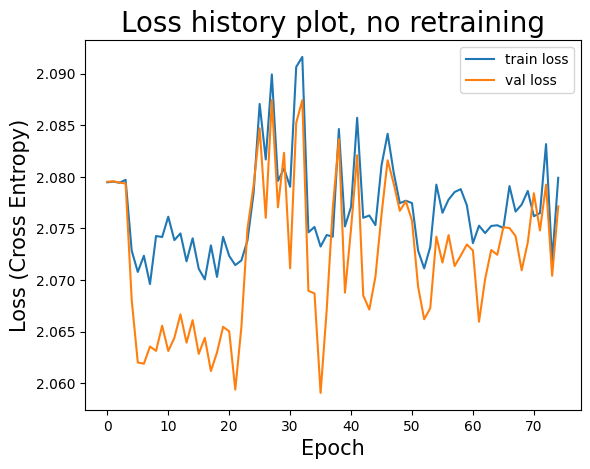

In [9]:
plt.figure()
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.title("Loss history plot, no retraining", fontsize = 20)
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Loss (Cross Entropy)", fontsize = 15)
plt.legend()
plt.savefig('losshistory1.png')
plt.show()

In [10]:
y_pred_proba = model(Xr_test.to(device))

In [11]:
acc = MulticlassAccuracy(num_classes = 8).to(device)
f1 = F1Score(task="multiclass", num_classes=8).to(device)

In [12]:
y_pred = torch.argmax(y_pred_proba, dim = 1)

In [13]:
y_test = y_test.to(device)

In [14]:
print(f'Accuracy {acc(y_pred, y_test[0:1000].view(-1))}')
print(f'F1 {f1(y_pred, y_test[0:1000].view(-1))}')

Accuracy 0.1536458283662796
F1 0.16987179219722748


In [15]:
print('Accuracy %s' % accuracy_score(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy()))
print('F1-score %s' % f1_score(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy(), average=None))
print(classification_report(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy()))

Accuracy 0.16987179487179488
F1-score [0.14634146 0.2371134  0.14285714 0.30188679 0.06451613 0.
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.18      0.12      0.15        48
           1       0.16      0.48      0.24        48
           2       0.10      0.25      0.14        24
           3       0.28      0.33      0.30        48
           4       0.14      0.04      0.06        48
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        24

    accuracy                           0.17       312
   macro avg       0.11      0.15      0.11       312
weighted avg       0.12      0.17      0.13       312



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
clrep = classification_report(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy(),output_dict=True)
df = pd.DataFrame(clrep).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
df.to_latex()

<ipython-input-17-893b2df4225d>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &    recall &  f1-score &     support \\\\\n\\midrule\n0            &   0.176471 &  0.125000 &  0.146341 &   48.000000 \\\\\n1            &   0.157534 &  0.479167 &  0.237113 &   48.000000 \\\\\n2            &   0.100000 &  0.250000 &  0.142857 &   24.000000 \\\\\n3            &   0.275862 &  0.333333 &  0.301887 &   48.000000 \\\\\n4            &   0.142857 &  0.041667 &  0.064516 &   48.000000 \\\\\n5            &   0.000000 &  0.000000 &  0.000000 &   24.000000 \\\\\n6            &   0.000000 &  0.000000 &  0.000000 &   48.000000 \\\\\n7            &   0.000000 &  0.000000 &  0.000000 &   24.000000 \\\\\naccuracy     &   0.169872 &  0.169872 &  0.169872 &    0.169872 \\\\\nmacro avg    &   0.106591 &  0.153646 &  0.111589 &  312.000000 \\\\\nweighted avg &   0.123496 &  0.169872 &  0.126352 &  312.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Pretraining with CREMA and retraining only the final network

In [18]:
batch_size = 16
epochs = 75
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_classes = 6

model = ClassifierTransformerModel(n_classes).double()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e3, 'k parameters')
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

crit = nn.CrossEntropyLoss()

train_loss = []
val_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets
    losses = estimate_loss()
    print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])


    # sample a batch of data
    for i in range(0, len(Xc_train), batch_size):
       optimizer.zero_grad()
       xb = Xc_train[i:i+batch_size].to(device)
       yb = yc_train[i:i+batch_size].to(device).view(-1)
       yv = yc_val[i:i+batch_size].to(device).view(-1)
       xv = Xc_val[i:i+batch_size].to(device)
       out = model(xb)
       # evaluate the loss
       loss = crit(out, yb)
       loss.backward()
       optimizer.step()

55.574 k parameters
epoch 0: train loss 1.7918, val loss 1.7920
epoch 1: train loss 1.7701, val loss 1.7677
epoch 2: train loss 1.7644, val loss 1.7664
epoch 3: train loss 1.7662, val loss 1.7645
epoch 4: train loss 1.7535, val loss 1.7575
epoch 5: train loss 1.7558, val loss 1.7623
epoch 6: train loss 1.7501, val loss 1.7529
epoch 7: train loss 1.7479, val loss 1.7531
epoch 8: train loss 1.7466, val loss 1.7521
epoch 9: train loss 1.7468, val loss 1.7575
epoch 10: train loss 1.7530, val loss 1.7599
epoch 11: train loss 1.7492, val loss 1.7554
epoch 12: train loss 1.7472, val loss 1.7536
epoch 13: train loss 1.7501, val loss 1.7580
epoch 14: train loss 1.7451, val loss 1.7538
epoch 15: train loss 1.7489, val loss 1.7589
epoch 16: train loss 1.7460, val loss 1.7608
epoch 17: train loss 1.7436, val loss 1.7594
epoch 18: train loss 1.7456, val loss 1.7528
epoch 19: train loss 1.7477, val loss 1.7564
epoch 20: train loss 1.7490, val loss 1.7520
epoch 21: train loss 1.7492, val loss 1.7594


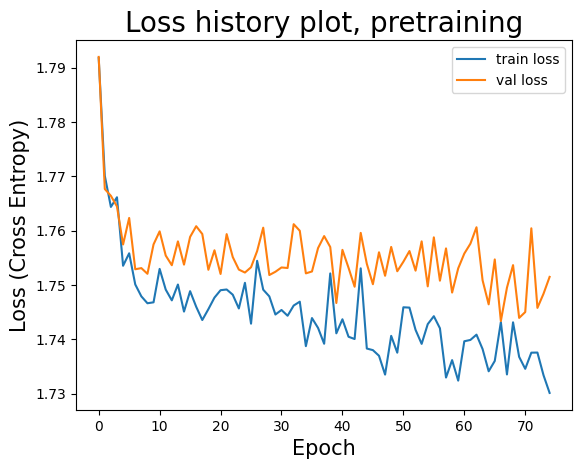

In [19]:
plt.figure()
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.title("Loss history plot, pretraining", fontsize = 20)
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Loss (Cross Entropy)", fontsize = 15)
plt.legend()
plt.savefig('loss_pre.png')
plt.show()

## Retraining

In [20]:
for param in model.parameters():
    param.requires_grad = False

In [21]:
class FinalLinear8(nn.Module):
  def __init__(self):
    super().__init__()
    self.fin_lin1 = nn.Linear(n_embd, 16)
    self.fin_lin2 = nn.Linear(16, 8)
    self.act = nn.ReLU()
    self.actoutput = nn.Softmax(dim = 0)

  def forward(self, x):
    x = self.act(self.fin_lin1(x))
    x = self.act(self.fin_lin2(x))
    x = self.actoutput(x)
    return x


model.fin_lin = FinalLinear8()

In [22]:
epochs = 50
m = (model.double()).to(device)
train_loss = []
val_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets
    losses = estimate_loss()
    print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])


    # sample a batch of data
    for i in range(0, len(Xr_train), batch_size):
       optimizer.zero_grad()
       xb = Xr_train[i:i+batch_size].to(device)
       yb = y_train[i:i+batch_size].to(device).view(-1)
       yv = y_val[i:i+batch_size].to(device).view(-1)
       xv = Xr_val[i:i+batch_size].to(device)
      #  print(xb.shape)
      #  print(yb.shape)
       out = model(xb)
       # print(out.shape)
       # evaluate the loss
       loss = crit(out, yb)
       loss.backward()
       optimizer.step()

epoch 0: train loss 2.0790, val loss 2.0784
epoch 1: train loss 2.0790, val loss 2.0787
epoch 2: train loss 2.0791, val loss 2.0785
epoch 3: train loss 2.0789, val loss 2.0785
epoch 4: train loss 2.0790, val loss 2.0786
epoch 5: train loss 2.0791, val loss 2.0785
epoch 6: train loss 2.0791, val loss 2.0785
epoch 7: train loss 2.0790, val loss 2.0785
epoch 8: train loss 2.0790, val loss 2.0785
epoch 9: train loss 2.0790, val loss 2.0785
epoch 10: train loss 2.0792, val loss 2.0786
epoch 11: train loss 2.0791, val loss 2.0786
epoch 12: train loss 2.0792, val loss 2.0786
epoch 13: train loss 2.0789, val loss 2.0786
epoch 14: train loss 2.0791, val loss 2.0785
epoch 15: train loss 2.0792, val loss 2.0787
epoch 16: train loss 2.0791, val loss 2.0785
epoch 17: train loss 2.0791, val loss 2.0786
epoch 18: train loss 2.0791, val loss 2.0784
epoch 19: train loss 2.0791, val loss 2.0786
epoch 20: train loss 2.0790, val loss 2.0785
epoch 21: train loss 2.0793, val loss 2.0783
epoch 22: train loss

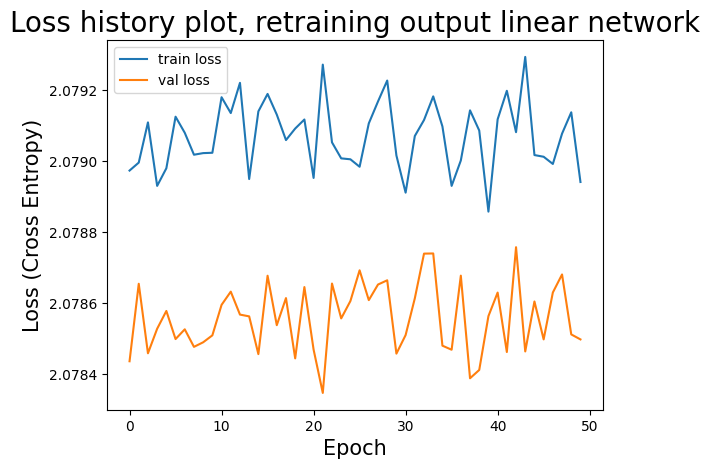

In [23]:
plt.figure()
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.title("Loss history plot, retraining output linear network", fontsize = 20)
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Loss (Cross Entropy)", fontsize = 15)
plt.legend()
plt.savefig('losshistory2.png')
plt.show()

In [24]:
y_pred_proba = model(Xr_test.to(device))

In [25]:
acc = MulticlassAccuracy(num_classes = 8).to(device)
f1 = F1Score(task="multiclass", num_classes=8).to(device)

In [26]:
y_pred = torch.argmax(y_pred_proba, dim = 1)

In [27]:
y_test = y_test.to(device)

In [28]:
print(f'Accuracy {acc(y_pred, y_test[0:1000].view(-1))}')
print(f'F1 {f1(y_pred, y_test[0:1000].view(-1))}')

Accuracy 0.1328125
F1 0.12179487198591232


In [29]:
print('Accuracy %s' % accuracy_score(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy()))
print('F1-score %s' % f1_score(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy(), average=None))
print(classification_report(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy()))

Accuracy 0.12179487179487179
F1-score [0.09302326 0.03703704 0.05263158 0.14814815 0.15686275 0.11764706
 0.14457831 0.15384615]
              precision    recall  f1-score   support

           0       0.11      0.08      0.09        48
           1       0.17      0.02      0.04        48
           2       0.07      0.04      0.05        24
           3       0.18      0.12      0.15        48
           4       0.15      0.17      0.16        48
           5       0.08      0.25      0.12        24
           6       0.17      0.12      0.14        48
           7       0.11      0.25      0.15        24

    accuracy                           0.12       312
   macro avg       0.13      0.13      0.11       312
weighted avg       0.14      0.12      0.11       312



In [30]:
clrep = classification_report(y_test[0:1000].cpu().numpy(), y_pred.cpu().numpy(),output_dict=True)
df = pd.DataFrame(clrep).transpose()

In [31]:
print(df.to_latex())

<ipython-input-31-893b2df4225d>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &    recall &  f1-score &     support \\\\\n\\midrule\n0            &   0.105263 &  0.083333 &  0.093023 &   48.000000 \\\\\n1            &   0.166667 &  0.020833 &  0.037037 &   48.000000 \\\\\n2            &   0.071429 &  0.041667 &  0.052632 &   24.000000 \\\\\n3            &   0.181818 &  0.125000 &  0.148148 &   48.000000 \\\\\n4            &   0.148148 &  0.166667 &  0.156863 &   48.000000 \\\\\n5            &   0.076923 &  0.250000 &  0.117647 &   24.000000 \\\\\n6            &   0.171429 &  0.125000 &  0.144578 &   48.000000 \\\\\n7            &   0.111111 &  0.250000 &  0.153846 &   24.000000 \\\\\naccuracy     &   0.121795 &  0.121795 &  0.121795 &    0.121795 \\\\\nmacro avg    &   0.129098 &  0.132812 &  0.112972 &  312.000000 \\\\\nweighted avg &   0.138932 &  0.121795 &  0.114110 &  312.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [58]:
print('\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &    recall &  f1-score &     support \\\\\n\\midrule\n0            &   0.105263 &  0.083333 &  0.093023 &   48.000000 \\\\\n1            &   0.166667 &  0.020833 &  0.037037 &   48.000000 \\\\\n2            &   0.071429 &  0.041667 &  0.052632 &   24.000000 \\\\\n3            &   0.181818 &  0.125000 &  0.148148 &   48.000000 \\\\\n4            &   0.148148 &  0.166667 &  0.156863 &   48.000000 \\\\\n5            &   0.076923 &  0.250000 &  0.117647 &   24.000000 \\\\\n6            &   0.171429 &  0.125000 &  0.144578 &   48.000000 \\\\\n7            &   0.111111 &  0.250000 &  0.153846 &   24.000000 \\\\\naccuracy     &   0.121795 &  0.121795 &  0.121795 &    0.121795 \\\\\nmacro avg    &   0.129098 &  0.132812 &  0.112972 &  312.000000 \\\\\nweighted avg &   0.138932 &  0.121795 &  0.114110 &  312.000000 \\\\\n\\bottomrule\n\\end{tabular}\n')#makes it easier to write tabular in latex file

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.105263 &  0.083333 &  0.093023 &   48.000000 \\
1            &   0.166667 &  0.020833 &  0.037037 &   48.000000 \\
2            &   0.071429 &  0.041667 &  0.052632 &   24.000000 \\
3            &   0.181818 &  0.125000 &  0.148148 &   48.000000 \\
4            &   0.148148 &  0.166667 &  0.156863 &   48.000000 \\
5            &   0.076923 &  0.250000 &  0.117647 &   24.000000 \\
6            &   0.171429 &  0.125000 &  0.144578 &   48.000000 \\
7            &   0.111111 &  0.250000 &  0.153846 &   24.000000 \\
accuracy     &   0.121795 &  0.121795 &  0.121795 &    0.121795 \\
macro avg    &   0.129098 &  0.132812 &  0.112972 &  312.000000 \\
weighted avg &   0.138932 &  0.121795 &  0.114110 &  312.000000 \\
\bottomrule
\end{tabular}



# Retraining all the network

In [32]:
for param in model.parameters():
    param.requires_grad = True

In [33]:
class FinalLinear8(nn.Module):
  def __init__(self):
    super().__init__()
    self.fin_lin1 = nn.Linear(n_embd, 16)
    self.fin_lin2 = nn.Linear(16, 8)
    self.act = nn.ReLU()
    self.actoutput = nn.Softmax(dim = 0)

  def forward(self, x):
    x = self.act(self.fin_lin1(x))
    x = self.act(self.fin_lin2(x))
    x = self.actoutput(x)
    return x


model.fin_lin = FinalLinear8()

In [46]:
epochs = 75
m = (model.double()).to(device)
train_loss = []
val_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets
    losses = estimate_loss()
    print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])


    # sample a batch of data
    for i in range(0, len(Xr_train), batch_size):
       optimizer.zero_grad()
       xb = Xr_train[i:i+batch_size].to(device)
       yb = y_train[i:i+batch_size].to(device).view(-1)
       yv = y_val[i:i+batch_size].to(device).view(-1)
       xv = Xr_val[i:i+batch_size].to(device)
      #  print(xb.shape)
      #  print(yb.shape)
       out = model(xb)
       # print(out.shape)
       # evaluate the loss
       loss = crit(out, yb)
       loss.backward()
       optimizer.step()

epoch 0: train loss 2.0637, val loss 2.0643
epoch 1: train loss 2.0623, val loss 2.0640
epoch 2: train loss 2.0609, val loss 2.0655
epoch 3: train loss 2.0643, val loss 2.0637
epoch 4: train loss 2.0651, val loss 2.0649
epoch 5: train loss 2.0632, val loss 2.0625
epoch 6: train loss 2.0631, val loss 2.0631
epoch 7: train loss 2.0604, val loss 2.0638
epoch 8: train loss 2.0615, val loss 2.0622
epoch 9: train loss 2.0620, val loss 2.0626
epoch 10: train loss 2.0622, val loss 2.0631
epoch 11: train loss 2.0607, val loss 2.0636
epoch 12: train loss 2.0621, val loss 2.0622
epoch 13: train loss 2.0628, val loss 2.0626
epoch 14: train loss 2.0620, val loss 2.0616
epoch 15: train loss 2.0614, val loss 2.0622
epoch 16: train loss 2.0616, val loss 2.0614
epoch 17: train loss 2.0603, val loss 2.0609
epoch 18: train loss 2.0594, val loss 2.0646
epoch 19: train loss 2.0616, val loss 2.0588
epoch 20: train loss 2.0613, val loss 2.0619
epoch 21: train loss 2.0608, val loss 2.0600
epoch 22: train loss

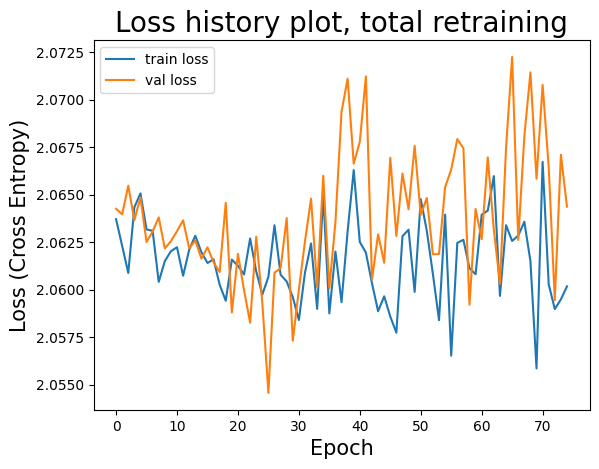

In [47]:
plt.figure()
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.title("Loss history plot, total retraining", fontsize = 20)
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Loss (Cross Entropy)", fontsize = 15)
plt.legend()
plt.savefig('losshistory3.png')
plt.show()

In [48]:
y_pred_proba = model(Xr_test.to(device))

In [49]:
acc = MulticlassAccuracy(num_classes = 8).to(device)
f1 = F1Score(task="multiclass", num_classes=8).to(device)

In [50]:
y_pred = torch.argmax(y_pred_proba, dim = 1)

In [51]:
y_test = torch.tensor(y_test).to(device)

<ipython-input-51-fcda10491ed3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).to(device)


In [52]:
y_test.shape

torch.Size([312])

In [53]:
print(f'Accuracy {acc(y_pred, y_test.view(-1))}')
print(f'F1 {f1(y_pred, y_test.view(-1))}')

Accuracy 0.140625
F1 0.16025641560554504


In [54]:
print('Accuracy %s' % accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy()))
print('F1-score %s' % f1_score(y_test.cpu().numpy(), y_pred.cpu().numpy(), average=None))
print(classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy()))

Accuracy 0.16025641025641027
F1-score [0.27692308 0.09375    0.         0.1627907  0.27027027 0.14035088
 0.16666667 0.        ]
              precision    recall  f1-score   support

           0       0.22      0.38      0.28        48
           1       0.07      0.12      0.09        48
           2       0.00      0.00      0.00        24
           3       0.18      0.15      0.16        48
           4       0.38      0.21      0.27        48
           5       0.12      0.17      0.14        24
           6       0.42      0.10      0.17        48
           7       0.00      0.00      0.00        24

    accuracy                           0.16       312
   macro avg       0.18      0.14      0.14       312
weighted avg       0.21      0.16      0.16       312



In [55]:
clreport = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy(), output_dict=True)

In [56]:
dfrep = pd.DataFrame(clreport).transpose()

In [59]:
print(dfrep.to_latex())#makes it easier to write tabular in latex file

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.219512 &  0.375000 &  0.276923 &   48.000000 \\
1            &   0.075000 &  0.125000 &  0.093750 &   48.000000 \\
2            &   0.000000 &  0.000000 &  0.000000 &   24.000000 \\
3            &   0.184211 &  0.145833 &  0.162791 &   48.000000 \\
4            &   0.384615 &  0.208333 &  0.270270 &   48.000000 \\
5            &   0.121212 &  0.166667 &  0.140351 &   24.000000 \\
6            &   0.416667 &  0.104167 &  0.166667 &   48.000000 \\
7            &   0.000000 &  0.000000 &  0.000000 &   24.000000 \\
accuracy     &   0.160256 &  0.160256 &  0.160256 &    0.160256 \\
macro avg    &   0.175152 &  0.140625 &  0.138844 &  312.000000 \\
weighted avg &   0.206248 &  0.160256 &  0.160089 &  312.000000 \\
\bottomrule
\end{tabular}



<ipython-input-59-78170b36cbe8>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfrep.to_latex())
